In [4]:
library(loadeR)
library(transformeR)
library(visualizeR)

Warning message:
"package 'loadeR' was built under R version 3.6.3"Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"

Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.


# Year - Season

El archivo tmax90 corresponde con el percentil de referencia obtenido en otro jupyter notebook

El archivo tmax_YS son los datos de la temperatura reordenados por año y luego por estacion. Estos días he estado mirando a ver si era problema del orden y lo tengo también ordenado como estación y en cada estación los años. Pero obtengo los mismos resultados.

In [4]:
tmax90 <- readRDS("1_quantiles/tmax90.rds")
tmax_YS <- readRDS("tmax_year_season.rds")

In [6]:
binarization_YS <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (year in names(grid_data)) {
    # Iterate over the seasons of each year
    for (season in names(grid_data[[year]])) {
      # Get current station data
      season_data <- grid_data[[year]][[season]]
      season_quantile <- quantile[[season]]
      
      # Dimension of the data
      dims <- dim(season_data$Data)
      # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[year]][[season]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}

In [7]:
tmax_bin_YS <- binarization_YS(tmax_YS, tmax90, "tmax")

In [12]:
str(tmax_bin_YS)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

Este archivo tmax_bin_YS os le adjunto también en el zip, que tarda algo de tiempo en generarse.

In [13]:
saveRDS(tmax_bin_YS, "tmax_year_season_binary.rds",compress = "xz")

In [2]:
capa_tierra <- readRDS("capa_tierra.rds")

In [11]:
winter <- list()
spring <- list()
summer <- list()
autumn <- list()
winter.mask <- list()  # Crear una lista para almacenar las sumas con máscara
spring.mask <- list()
summer.mask <- list()
autumn.mask <- list()
for (i in 1:length(data.bin)){
    winter[[paste0("winter.", i)]] <- climatology(data.bin[[i]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE))
    winter.mask[[paste0("winter.", i, ".masked")]] <- gridArithmetics(winter[[paste0("winter.", i)]], mask, operator = "*")
    spring[[paste0("spring.", i)]] <- climatology(data.bin[[i]]$Spring, clim.fun = list(FUN = "sum", na.rm = TRUE))
    spring.mask[[paste0("spring.", i, ".masked")]] <- gridArithmetics(spring[[paste0("spring.", i)]], mask, operator = "*")
    summer[[paste0("summer.", i)]] <- climatology(data.bin[[i]]$Summer, clim.fun = list(FUN = "sum", na.rm = TRUE))
    summer.mask[[paste0("summer.", i, ".masked")]] <- gridArithmetics(summer[[paste0("summer.", i)]], mask, operator = "*")
    autumn[[paste0("autumn.", i)]] <- climatology(data.bin[[i]]$Autumn, clim.fun = list(FUN = "sum", na.rm = TRUE))
    autumn.mask[[paste0("autumn.", i, ".masked")]] <- gridArithmetics(autumn[[paste0("autumn.", i)]], mask, operator = "*")
}


[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...


[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] - Computing climatology...
[2024-03-13 12:14:38] - Done.
[2024-03-13 12:14:38] 

In [12]:
for (i in 1:length(sumas)){
    print(spatialPlot(makeMultiGrid(sumas[i], sumas.mask[i]), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))

}

ERROR: Error in eval(expr, envir, enclos): objeto 'sumas' no encontrado


In [14]:
winter.plus <- do.call(bindGrid, c(winter.mask, list(dimension = "time", skip.temporal.check = TRUE)))
spring.plus <- do.call(bindGrid, c(spring.mask, list(dimension = "time", skip.temporal.check = TRUE)))
summer.plus <- do.call(bindGrid, c(summer.mask, list(dimension = "time", skip.temporal.check = TRUE)))
autumn.plus <- do.call(bindGrid, c(autumn.mask, list(dimension = "time", skip.temporal.check = TRUE)))


In [15]:
winter.plus.sum <- climatology(winter.plus, clim.fun = list(FUN = "sum", na.rm = TRUE))
spring.plus.sum <- climatology(spring.plus, clim.fun = list(FUN = "sum", na.rm = TRUE))
summer.plus.sum <- climatology(summer.plus, clim.fun = list(FUN = "sum", na.rm = TRUE))
autumn.plus.sum <- climatology(autumn.plus, clim.fun = list(FUN = "sum", na.rm = TRUE))

[2024-03-13 12:15:02] - Computing climatology...
[2024-03-13 12:15:02] - Done.
[2024-03-13 12:15:02] - Computing climatology...
[2024-03-13 12:15:02] - Done.


[2024-03-13 12:15:02] - Computing climatology...
[2024-03-13 12:15:02] - Done.
[2024-03-13 12:15:02] - Computing climatology...
[2024-03-13 12:15:02] - Done.


In [16]:
winter.plus.sum.masked <- gridArithmetics(winter.plus.sum, mask, operator = "*")
spring.plus.sum.masked <- gridArithmetics(spring.plus.sum, mask, operator = "*")
summer.plus.sum.masked <- gridArithmetics(summer.plus.sum, mask, operator = "*")
autumn.plus.sum.masked <- gridArithmetics(autumn.plus.sum, mask, operator = "*")

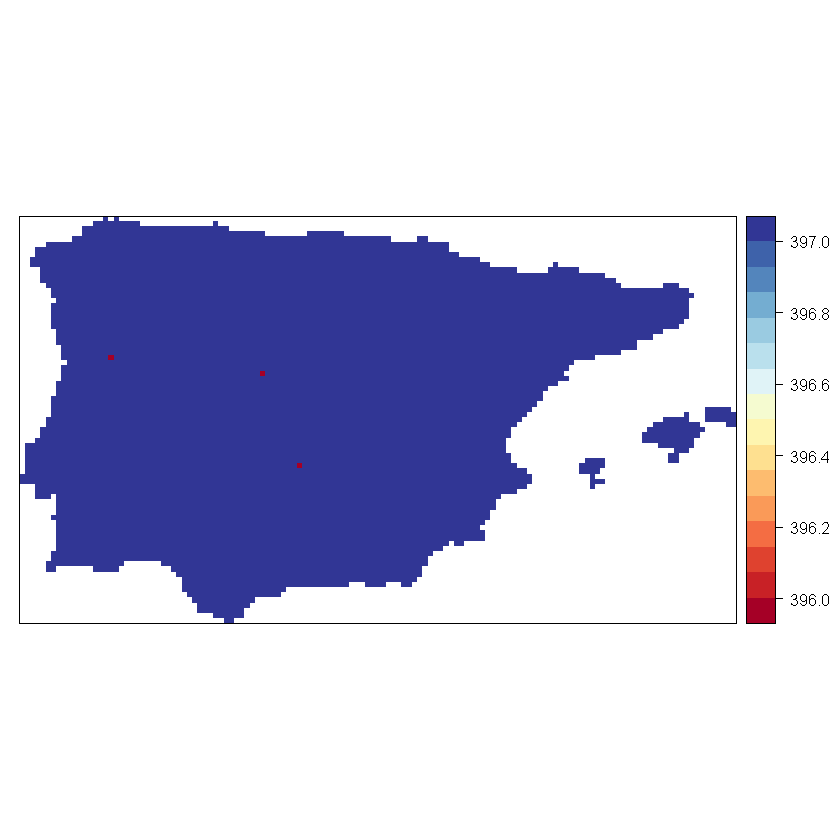

In [17]:
spatialPlot(suma_total_mask)

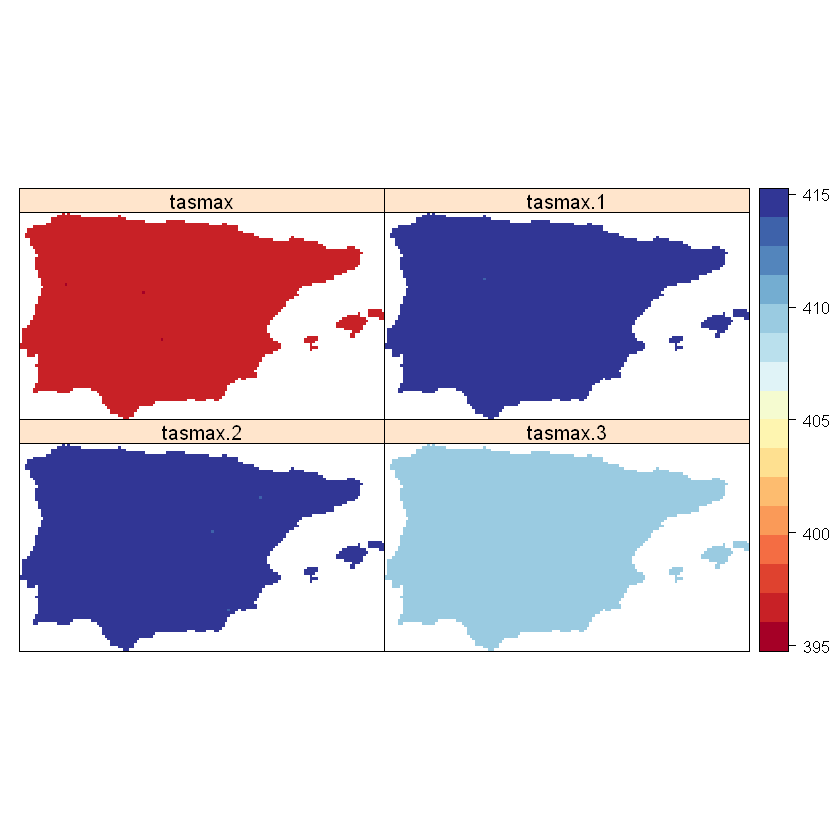

In [28]:
print(spatialPlot(makeMultiGrid(suma_total_mask, spring.plus.sum.masked, summer.plus.sum.masked, autumn.plus.sum.masked, skip.temporal.check = TRUE), backdroptheme="coastline", as.table=TRUE, layout=c(2,2)))

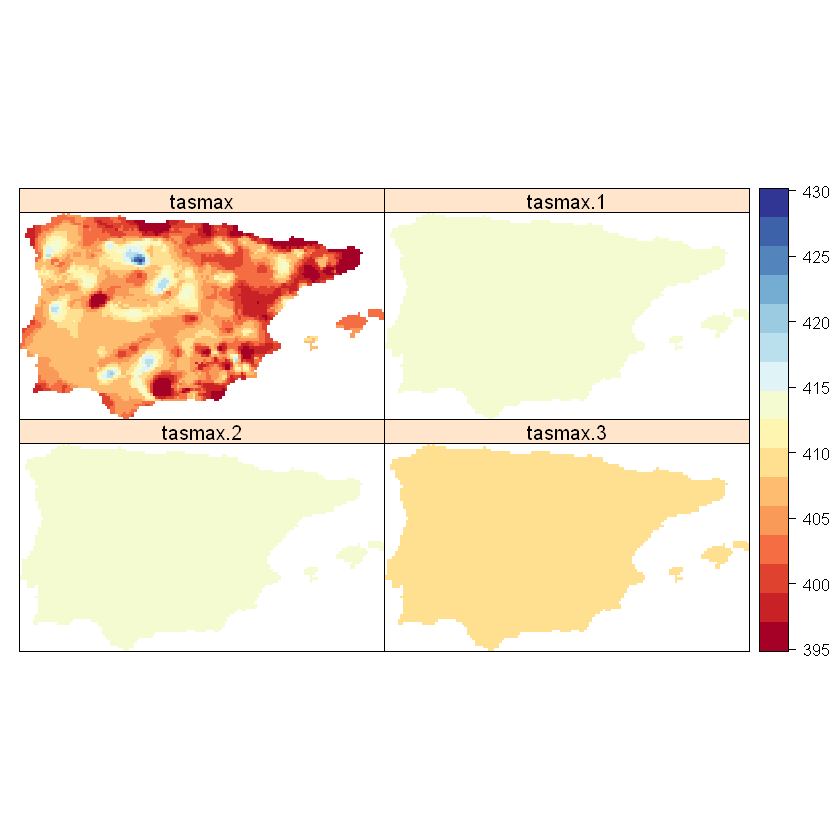

In [18]:
print(spatialPlot(makeMultiGrid(winter.plus.sum.masked, spring.plus.sum.masked, summer.plus.sum.masked, autumn.plus.sum.masked, skip.temporal.check = TRUE), backdroptheme="coastline", as.table=TRUE, layout=c(2,2)))

In [64]:
str(winter.plus.sum.masked)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "tasmax"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  ..- attr(*, "units")= chr "degree_Celsius"
  ..- attr(*, "longname")= chr "tasmax"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
  ..- attr(*, "subset")= chr "time"
 $ Data    : num [1, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 2
  ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "resX")= num 0.101
  ..- attr(*, "resY")= num 0.1
 $ Dates   :List of 2
  ..$ start: Named chr "1971-01-01 00:00:00 GMT"
  .. ..- attr(*, "names")= chr "winter.1.masked"

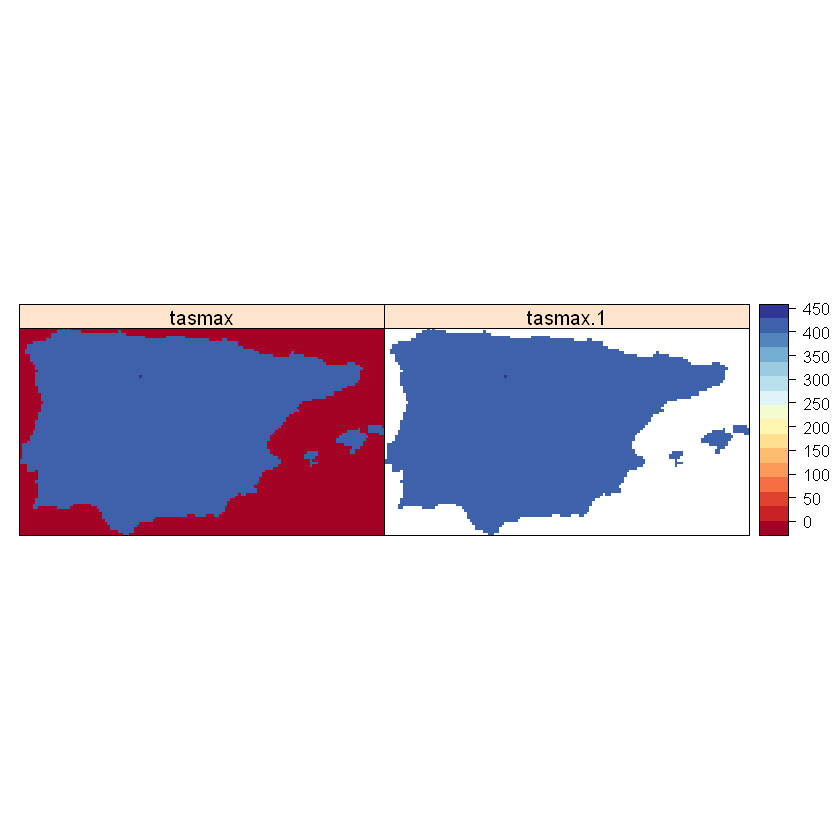

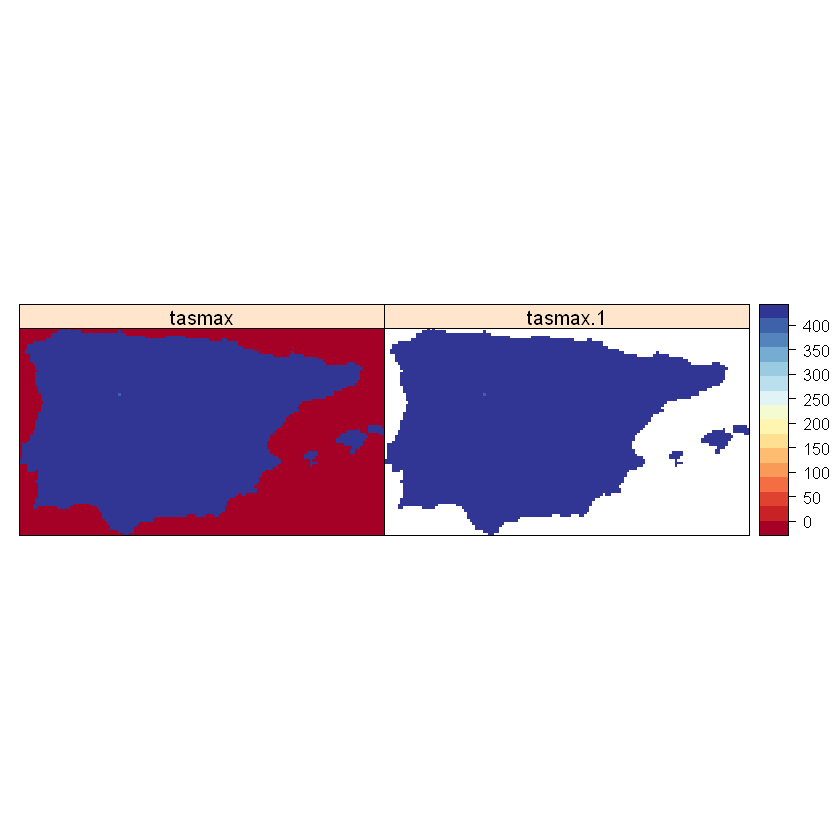

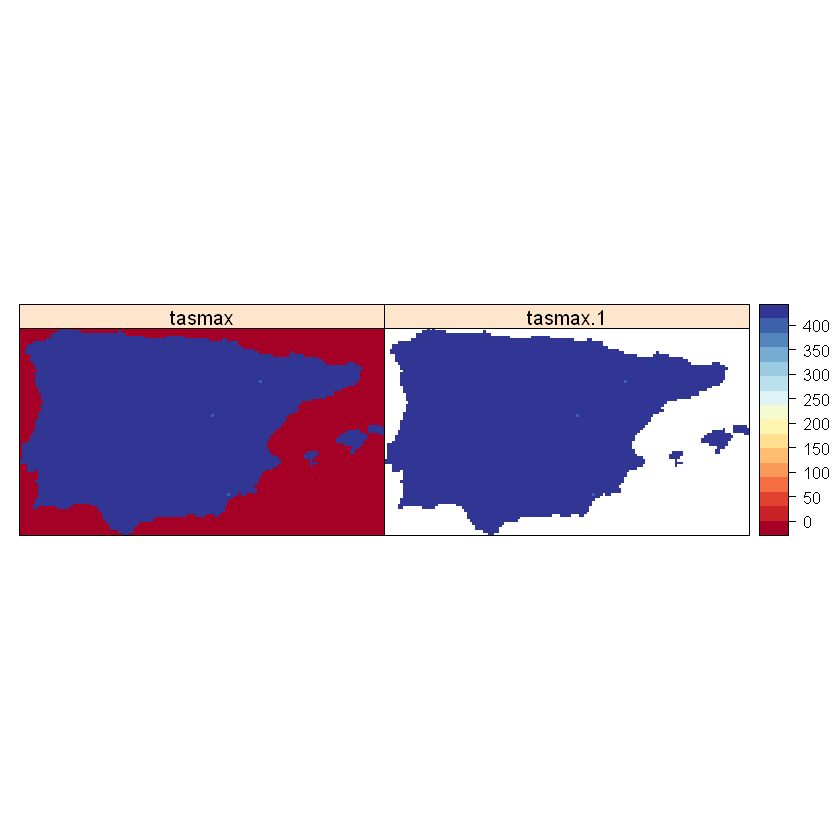

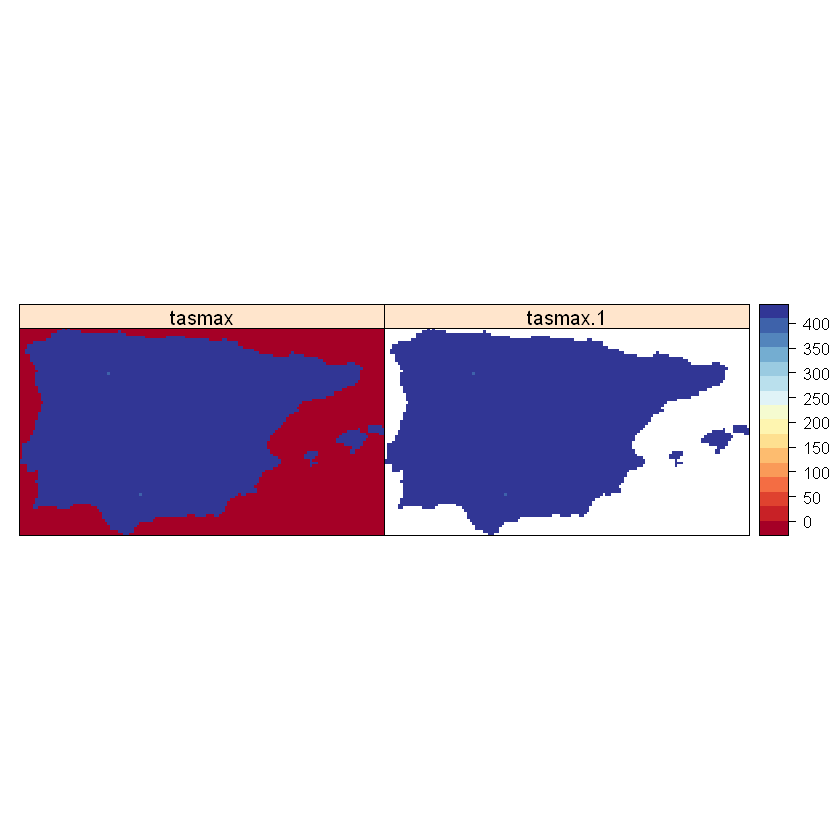

In [56]:
print(spatialPlot(makeMultiGrid(winter.plus.sum, winter.plus.sum.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))
print(spatialPlot(makeMultiGrid(spring.plus.sum, spring.plus.sum.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))
print(spatialPlot(makeMultiGrid(summer.plus.sum, summer.plus.sum.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))
print(spatialPlot(makeMultiGrid(autumn.plus.sum, autumn.plus.sum.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))


In [48]:
a.sum <- climatology(a, clim.fun = list(FUN = "sum", na.rm = TRUE))
b.sum <- climatology(b, clim.fun = list(FUN = "sum", na.rm = TRUE))
b.sum.masked <- gridArithmetics(b.sum, mask, operator = "*")

[2024-03-13 11:56:11] - Computing climatology...
[2024-03-13 11:56:11] - Done.
[2024-03-13 11:56:11] - Computing climatology...
[2024-03-13 11:56:11] - Done.


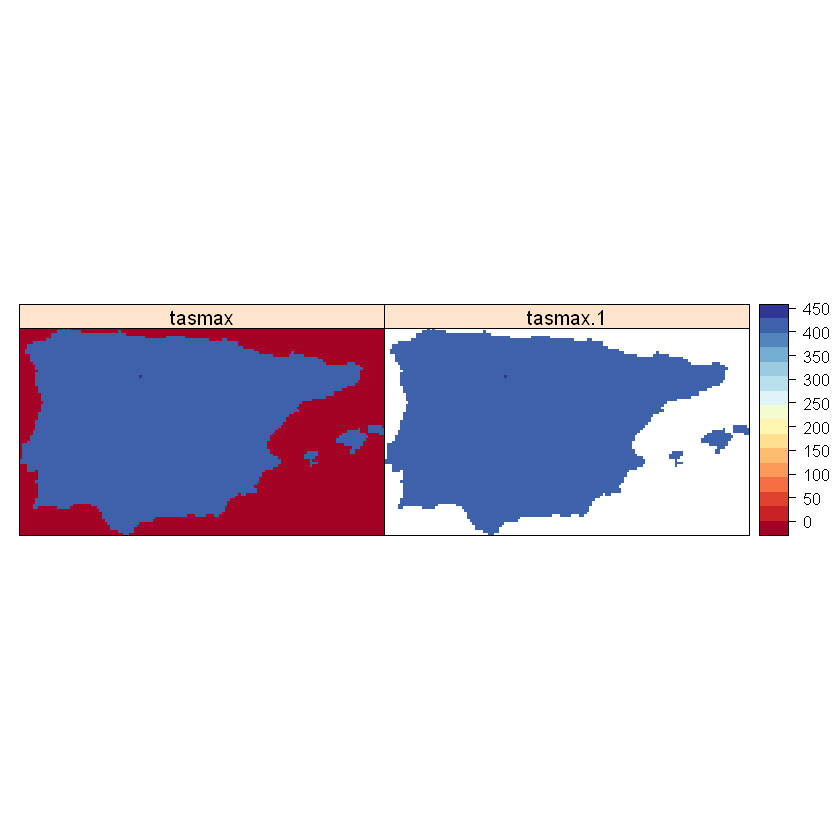

In [49]:
print(spatialPlot(makeMultiGrid(b.sum, b.sum.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))


In [22]:
b <- bindGrid(sumas.mask[1], sumas.mask[2], sumas.mask[3], sumas.mask[4], sumas.mask[5], sumas.mask[6], sumas.mask[7], sumas.mask[8], sumas.mask[9], sumas.mask[10], sumas.mask[11], sumas.mask[12], sumas.mask[13], sumas.mask[14], sumas.mask[15],
              sumas.mask[16], sumas.mask[17], sumas.mask[18], sumas.mask[19], sumas.mask[20], sumas.mask[21], sumas.mask[22], sumas.mask[23], sumas.mask[24], sumas.mask[25], sumas.mask[26], sumas.mask[27], sumas.mask[28], sumas.mask[29], sumas.mask[30], 
              sumas.mask[31], sumas.mask[32], sumas.mask[33], sumas.mask[34], sumas.mask[35], sumas.mask[36], sumas.mask[37], sumas.mask[38], sumas.mask[39], sumas.mask[40], sumas.mask[41], sumas.mask[42], sumas.mask[43], sumas.mask[44], sumas.mask[45], 
              dimension = "time", skip.temporal.check = TRUE)



ERROR: Error in attr(grid$Data, "dimensions") <- dimNames: se intenta especificar un atributo en un NULL


In [5]:
# suma1 <- climatology(data.bin[[1]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma2 <- climatology(data.bin[[2]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma3 <- climatology(data.bin[[3]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma4 <- climatology(data.bin[[4]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma5 <- climatology(data.bin[[5]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma6 <- climatology(data.bin[[6]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma7 <- climatology(data.bin[[7]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma8 <- climatology(data.bin[[8]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma9 <- climatology(data.bin[[9]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma10 <- climatology(data.bin[[10]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma11 <- climatology(data.bin[[11]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma12 <- climatology(data.bin[[12]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma13 <- climatology(data.bin[[13]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma14 <- climatology(data.bin[[14]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma15 <- climatology(data.bin[[15]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma16 <- climatology(data.bin[[16]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma17 <- climatology(data.bin[[17]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma18 <- climatology(data.bin[[18]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma19 <- climatology(data.bin[[19]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma20 <- climatology(data.bin[[20]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma21 <- climatology(data.bin[[21]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma22 <- climatology(data.bin[[22]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma23 <- climatology(data.bin[[23]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma24 <- climatology(data.bin[[24]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma25 <- climatology(data.bin[[25]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma26 <- climatology(data.bin[[26]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma27 <- climatology(data.bin[[27]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma28 <- climatology(data.bin[[28]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma29 <- climatology(data.bin[[29]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma30 <- climatology(data.bin[[30]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma31 <- climatology(data.bin[[31]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma32 <- climatology(data.bin[[32]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma33 <- climatology(data.bin[[33]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma34 <- climatology(data.bin[[34]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma35 <- climatology(data.bin[[35]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma36 <- climatology(data.bin[[36]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma37 <- climatology(data.bin[[37]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma38 <- climatology(data.bin[[38]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma39 <- climatology(data.bin[[39]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma40 <- climatology(data.bin[[40]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma41 <- climatology(data.bin[[41]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma42 <- climatology(data.bin[[42]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma43 <- climatology(data.bin[[43]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma44 <- climatology(data.bin[[44]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
suma45 <- climatology(data.bin[[45]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno



[2024-03-13 12:13:56] - Computing climatology...
[2024-03-13 12:13:56] - Done.
[2024-03-13 12:13:56] - Computing climatology...
[2024-03-13 12:13:56] - Done.
[2024-03-13 12:13:56] - Computing climatology...
[2024-03-13 12:13:56] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[2024-03-13 12:13:57] - Done.
[2024-03-13 12:13:57] - Computing climatology...
[20

In [6]:
# suma1.masked<- gridArithmetics(suma1, mask, operator="*")
suma2.masked<- gridArithmetics(suma2, mask, operator="*")
suma3.masked<- gridArithmetics(suma3, mask, operator="*")
suma4.masked<- gridArithmetics(suma4, mask, operator="*")
suma5.masked<- gridArithmetics(suma5, mask, operator="*")
suma6.masked<- gridArithmetics(suma6, mask, operator="*")
suma7.masked<- gridArithmetics(suma7, mask, operator="*")
suma8.masked<- gridArithmetics(suma8, mask, operator="*")
suma9.masked<- gridArithmetics(suma9, mask, operator="*")
suma10.masked<- gridArithmetics(suma10, mask, operator="*")
suma11.masked<- gridArithmetics(suma11, mask, operator="*")
suma12.masked<- gridArithmetics(suma12, mask, operator="*")
suma13.masked<- gridArithmetics(suma13, mask, operator="*")
suma14.masked<- gridArithmetics(suma14, mask, operator="*")
suma15.masked<- gridArithmetics(suma15, mask, operator="*")
suma16.masked<- gridArithmetics(suma16, mask, operator="*")
suma17.masked<- gridArithmetics(suma17, mask, operator="*")
suma18.masked<- gridArithmetics(suma18, mask, operator="*")
suma19.masked<- gridArithmetics(suma19, mask, operator="*")
suma20.masked<- gridArithmetics(suma20, mask, operator="*")
suma21.masked<- gridArithmetics(suma21, mask, operator="*")
suma22.masked<- gridArithmetics(suma22, mask, operator="*")
suma23.masked<- gridArithmetics(suma23, mask, operator="*")
suma24.masked<- gridArithmetics(suma24, mask, operator="*")
suma25.masked<- gridArithmetics(suma25, mask, operator="*")
suma26.masked<- gridArithmetics(suma26, mask, operator="*")
suma27.masked<- gridArithmetics(suma27, mask, operator="*")
suma28.masked<- gridArithmetics(suma28, mask, operator="*")
suma29.masked<- gridArithmetics(suma29, mask, operator="*")
suma30.masked<- gridArithmetics(suma30, mask, operator="*")
suma31.masked<- gridArithmetics(suma31, mask, operator="*")
suma32.masked<- gridArithmetics(suma32, mask, operator="*")
suma33.masked<- gridArithmetics(suma33, mask, operator="*")
suma34.masked<- gridArithmetics(suma34, mask, operator="*")
suma35.masked<- gridArithmetics(suma35, mask, operator="*")
suma36.masked<- gridArithmetics(suma36, mask, operator="*")
suma37.masked<- gridArithmetics(suma37, mask, operator="*")
suma38.masked<- gridArithmetics(suma38, mask, operator="*")
suma39.masked<- gridArithmetics(suma39, mask, operator="*")
suma40.masked<- gridArithmetics(suma40, mask, operator="*")
suma41.masked<- gridArithmetics(suma41, mask, operator="*")
suma42.masked<- gridArithmetics(suma42, mask, operator="*")
suma43.masked<- gridArithmetics(suma43, mask, operator="*")
suma44.masked<- gridArithmetics(suma44, mask, operator="*")
suma45.masked<- gridArithmetics(suma45, mask, operator="*")

In [25]:
suma_mask <- bindGrid(suma2.masked, suma3.masked, suma4.masked, suma5.masked, suma6.masked, suma7.masked, suma8.masked, suma9.masked, suma10.masked, suma11.masked, suma12.masked, suma13.masked, suma14.masked, suma15.masked, suma16.masked, suma17.masked, suma18.masked, suma19.masked, suma20.masked, suma21.masked, suma22.masked, suma23.masked, suma24.masked, suma25.masked, suma26.masked, suma27.masked, suma28.masked, suma29.masked, suma30.masked, suma31.masked, suma32.masked, suma33.masked, suma34.masked, suma35.masked, suma36.masked, suma37.masked, suma38.masked, suma39.masked, suma40.masked, suma41.masked, suma42.masked, suma43.masked, suma44.masked, suma45.masked, dimension = "time", skip.temporal.check = TRUE)

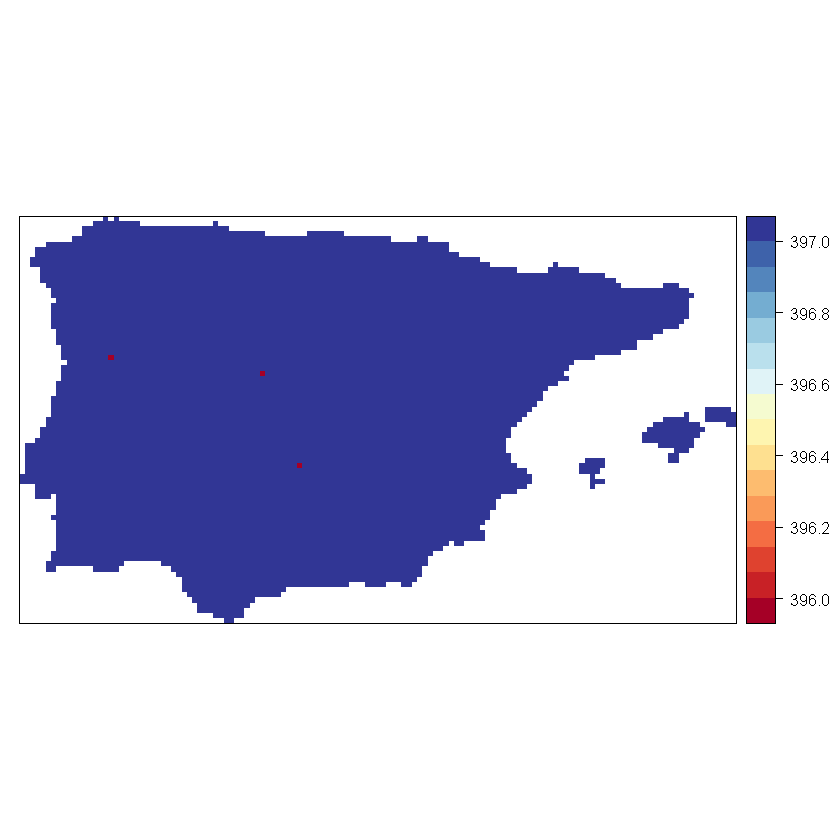

In [27]:
spatialPlot(suma_total_mask, skip.temporal.check = TRUE)

[2024-03-13 12:17:35] - Computing climatology...
[2024-03-13 12:17:35] - Done.


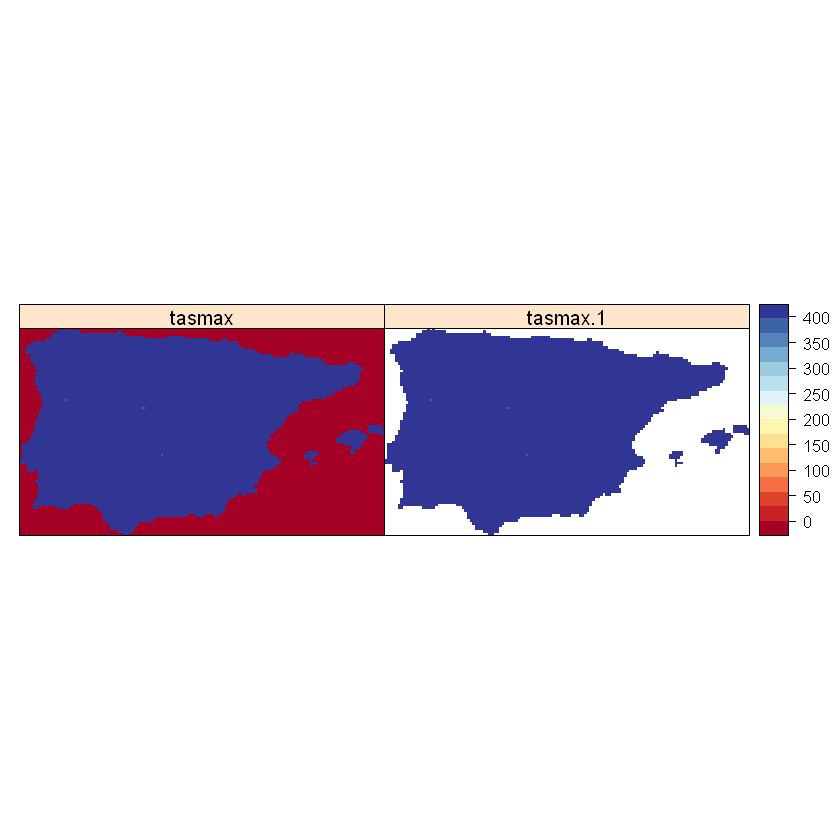

In [26]:
suma_total <- climatology(suma_mask, clim.fun = list(FUN = "sum", na.rm = TRUE))
suma_total_mask <- gridArithmetics(suma_total, mask, operator = "*")
print(spatialPlot(makeMultiGrid(suma_total, suma_total_mask), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))


In [2]:
data.bin <- readRDS('tmax_year_season_binary.rds')
mask <- readRDS('capa_tierra.rds')

# suma1 <- climatology(data.bin[[1]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
# suma2 <- climatology(data.bin[[2]]$Winter, clim.fun = list(FUN = "sum", na.rm = TRUE)) # solo suma en el primer invierno
# suma1.masked<- gridArithmetics(suma1, mask, operator="*")
# suma2.masked<- gridArithmetics(suma2, mask, operator="*")
# print(spatialPlot(makeMultiGrid(suma1, suma1.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))
# print(spatialPlot(makeMultiGrid(suma2, suma2.masked), backdroptheme="coastline", as.table=TRUE, layout=c(2,1)))


Con esta función se suman los eventos en cada estación, se pasan los 45 años * 4 estaciones, de una dimension [1:45,1:79,1:137] -> [1,1:79,1:137]

In [15]:
# Función para sumar los eventos de cada estación
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid[[year]])) {
      # Get the data of the current season
      season_data1 <- grid[[year]][[season]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      # Update the data grid with the result
      grid1[[year]][[season]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [16]:
sum_bin_YS <- sum_events(tmax_bin_YS)

[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[20

Con estos bloques de código, se pasa de tener 45 años y cada año 4 estaciones de [1,1:79,1:137] -> 4 estaciones con [1,1:79,1:137]

In [17]:
# Función para realizar bindGrid de una estación específica para todos los años
bindGridEstaciones <- function(datos, estacion) {
  # Extraemos los años 
  years <- names(datos)

  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  
  # Iteramos sobre los años
  for (year in years) {
    # Obtenemos el grid para la estación especificada
    grid <- datos[[year]][[estacion]]
    # Lo añadimos a la lista
    lista_grids[[year]] <- grid
  }
  
  # Realizamos el bindGrid con todos los grids de la lista
  resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
  return(resultado)
}

En el siguiente bloque de código es dónde uso la capa tierra. Si se quita la linea de capa_tierra, se tiene en cuenta el mar aunque na.rm =TRUE

Puede hacerse individualmente para una sola estación

In [22]:
datosWinter <- bindGridEstaciones(sum_bin_YS, "Winter")
datosWinter <- climatology(datosWinter, clim.fun = list(FUN = "sum", na.rm = TRUE))

[2024-03-12 11:58:44] - Computing climatology...
[2024-03-12 11:58:44] - Done.


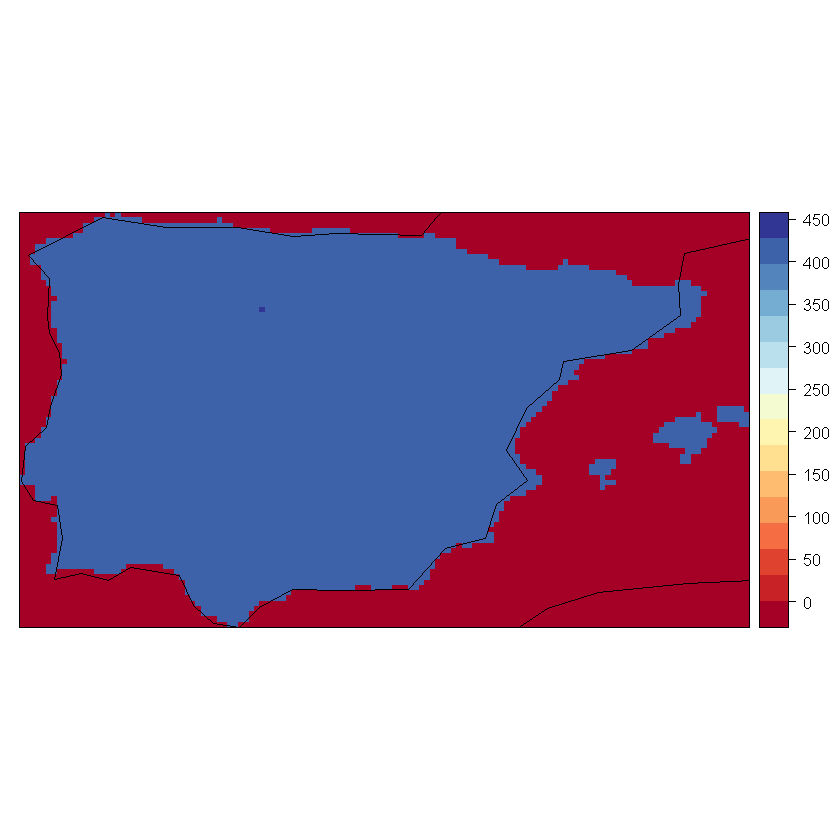

In [24]:
spatialPlot(datosWinter, backdrop.theme = "coastline")

Aplicando la capa tierra

In [25]:
datosWinter_tierra <- gridArithmetics(datosWinter, capa_tierra, operator = "*")

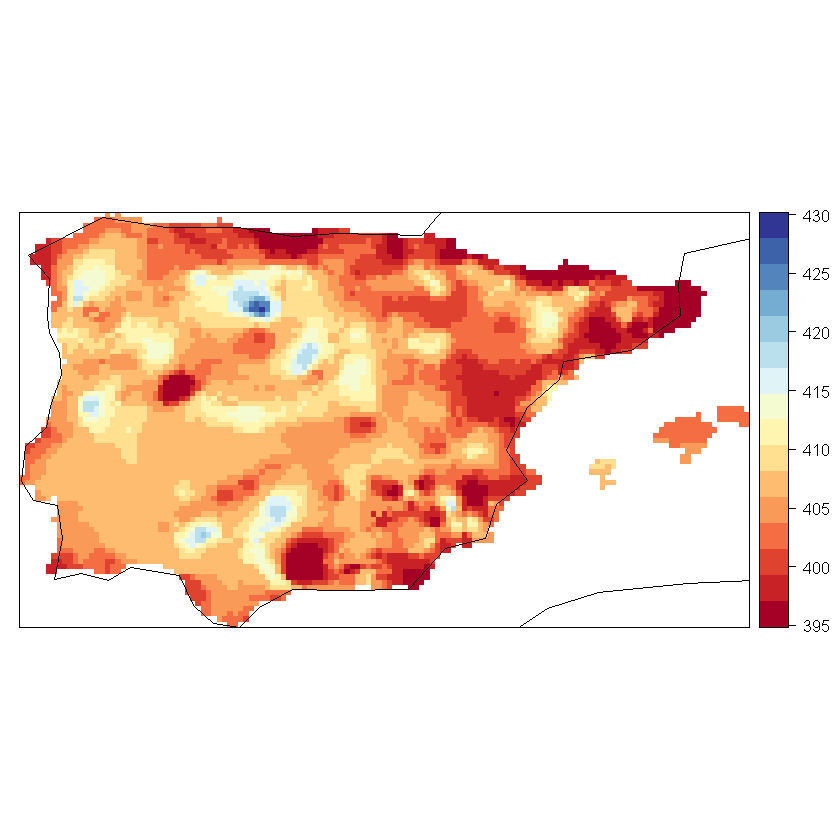

In [26]:
spatialPlot(datosWinter_tierra, backdrop.theme = "coastline")

Bucle para ejecutar todos los datos de todas las estaciones

In [29]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sum_bin_YS, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  # datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod[[estacion]] <- datos_estacion
}


[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:06] - Computing climatology...
[2024-03-12 12:01:06] - Done.


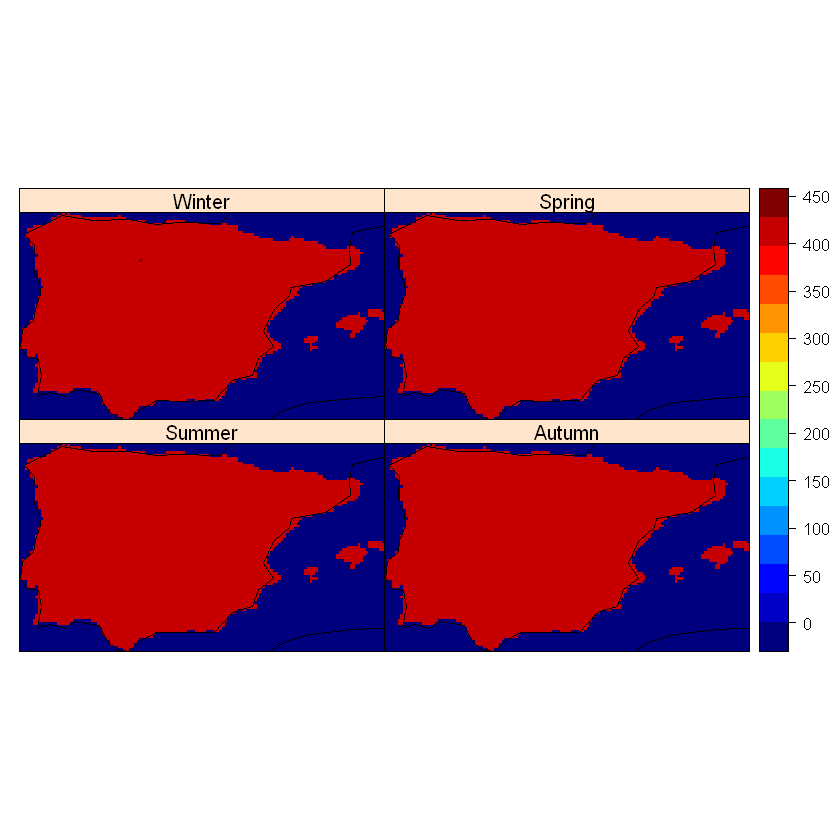

In [30]:
bind <- bindGrid(dataPeriod$Winter, dataPeriod$Spring, dataPeriod$Summer, dataPeriod$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

CON CAPA TIERRA

In [31]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod_tierra <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sum_bin_YS, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod_tierra[[estacion]] <- datos_estacion
}

[2024-03-12 12:03:06] - Computing climatology...
[2024-03-12 12:03:06] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:07] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:07] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:08] - Done.


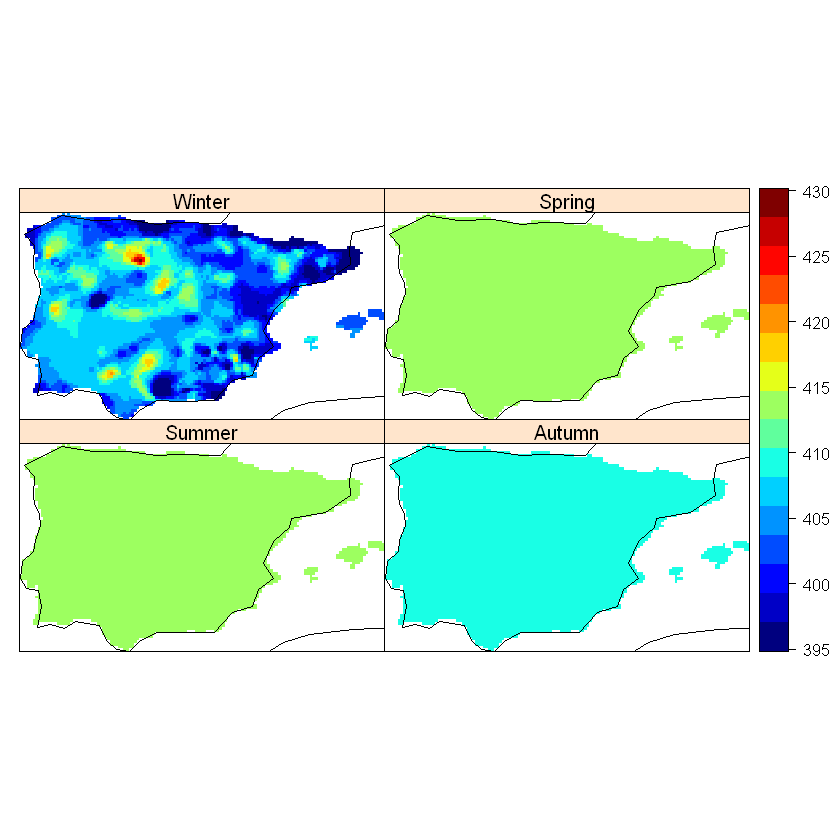

In [32]:
bind_tierra <- bindGrid(dataPeriod_tierra$Winter, dataPeriod_tierra$Spring, dataPeriod_tierra$Summer, dataPeriod_tierra$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind_tierra, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

# Season - Year

In [2]:
tmax90 <- readRDS("1_quantiles/tmax90.rds")
tmax_SY <- readRDS("tmax_season_year.rds")

In [3]:
binarization_SY <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (season in names(grid_data)) {
    # Iterate over the seasons of each year
    for (year in names(grid_data[[season]])) {
      # Get current station data
      season_data <- grid_data[[season]][[year]]
      season_quantile <- quantile[[season]]

      # Dimension of the data
      dims <- dim(season_data$Data)
    # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[season]][[year]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}

In [4]:
tmax_bin_SY <- binarization_SY(tmax_SY, tmax90, "tmax")

In [5]:
str(tmax_bin_SY)

List of 4
 $ Winter:List of 45
  ..$ 1971:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

In [6]:
tmax_bin_SY_2 <- tmax_bin_SY

In [7]:
tmax_bin_SY_2$Winter <- tmax_bin_SY_2$Winter[-1]

In [8]:
str(object = tmax_bin_SY_2)

List of 4
 $ Winter:List of 44
  ..$ 1972:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:91, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

In [9]:
# Create a function that iter over the years and seasons of one data grid and execute the function climatology to summarize the data
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (season in names(grid)) {
    # Iterate over the seasons in each year
    for (year in names(grid[[season]])) {
      # Get the data of the current season
      season_data1 <- grid[[season]][[year]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      # sum_events <- gridArithmetics(sum_events, capa_tierra, operator = "*")
      # Update the data grid with the result
      grid1[[season]][[year]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [11]:
sum_tmax_bin_SY <- sum_events(tmax_bin_SY)

[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:29] - Done.
[2024-03-12 13:24:29] - Computing climatology...
[2024-03-12 13:24:30] - Done.
[2024-03-12 13:24:30] - Computing climatology...
[2024-03-12 13:24:30] - Done.
[2024-03-12 13:24:30] - Computing climatology...
[2024-03-12 13:24:30] - Done.
[2024-03-12 13:24:30] - Computing climatology...
[2024-03-12 13:24:30] - Done.
[2024-03-12 13:24:30] - Computing climatology...
[2024-03-12 13:24:30] - Done.
[2024-03-12 13:24:30] - Computing climatology...
[20

In [12]:
sum_tmax_bin_SY_2 <- sum_events(tmax_bin_SY_2)

[2024-03-12 13:24:46] - Computing climatology...


[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:47] - Done.
[2024-03-12 13:24:47] - Computing climatology...
[2024-03-12 13:24:48] - Done.
[2024-03-12 13:24:48] - Computing climatology...
[2024-03-12 13:24:48] - Done.
[2024-03-12 13:24:48] - Computing climatology...
[2024-03-12 13:24:48] - Done.
[2024-03-12 13:24:48] 

In [15]:
# Función para realizar bindGrid de una estación específica para varios años
bindGridEstaciones <- function(datos) {
  # Extraemos los años disponibles en los datos
  years <- names(datos)
  
  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  final <- list()
  
  # Iteramos sobre los años
  for (season in names(datos)) {
    for (year in names(datos[[season]])) {
      # Obtenemos el grid para la estación especificada
      grid <- datos[[season]][[year]]
      # Lo añadimos a la lista
      lista_grids[[year]] <- grid
    }
    resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
    resultado <- climatology(resultado, clim.fun = list(FUN = "sum", na.rm = TRUE))
    final[[season]] <- resultado
  }
  return(final)
}

In [16]:
a <- bindGridEstaciones(sum_tmax_bin_SY)

[2024-03-12 13:28:51] - Computing climatology...
[2024-03-12 13:28:51] - Done.
[2024-03-12 13:28:51] - Computing climatology...
[2024-03-12 13:28:51] - Done.
[2024-03-12 13:28:52] - Computing climatology...
[2024-03-12 13:28:52] - Done.
[2024-03-12 13:28:52] - Computing climatology...
[2024-03-12 13:28:52] - Done.


SIN CAPA TIERRA (1971-2015)

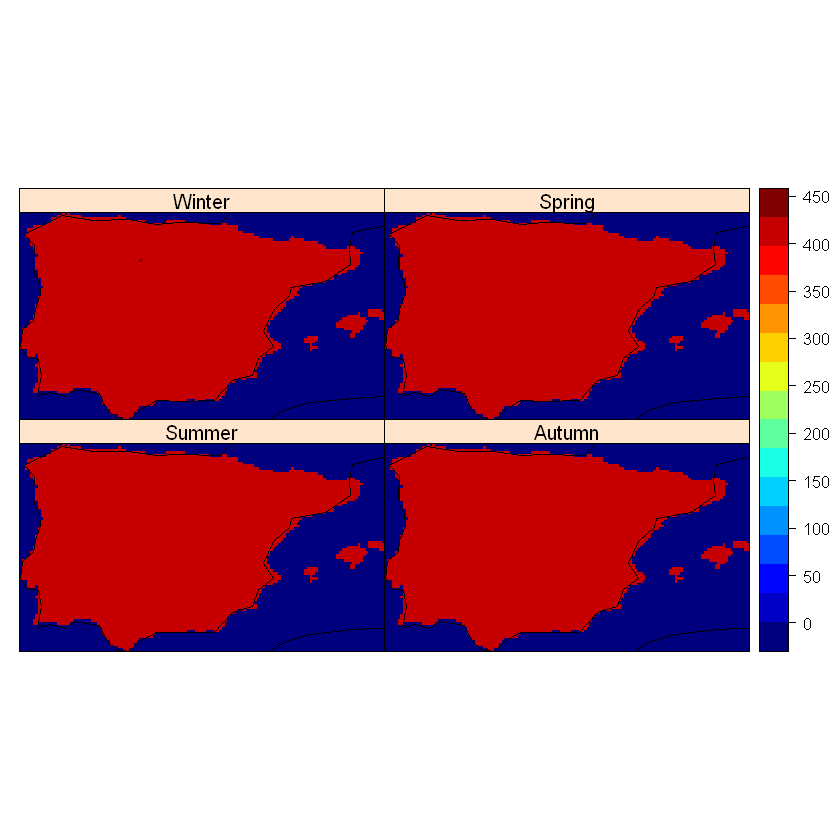

In [17]:
bind1 <- bindGrid(a$Winter, a$Spring, a$Summer, a$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind1, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

SIN CAPA TIERRA (1972-2015 Winter / 1971-2015 Rest)

In [18]:
b <- bindGridEstaciones(sum_tmax_bin_SY_2)

[2024-03-12 13:29:15] - Computing climatology...
[2024-03-12 13:29:15] - Done.
[2024-03-12 13:29:15] - Computing climatology...
[2024-03-12 13:29:15] - Done.
[2024-03-12 13:29:16] - Computing climatology...
[2024-03-12 13:29:16] - Done.
[2024-03-12 13:29:16] - Computing climatology...
[2024-03-12 13:29:16] - Done.


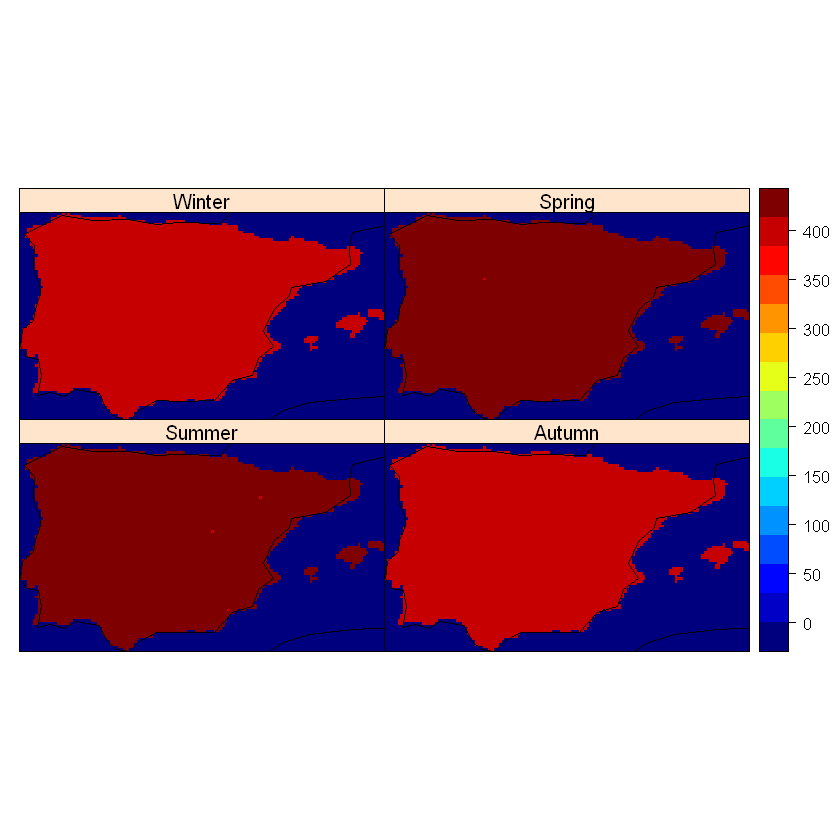

In [19]:
bind2 <- bindGrid(b$Winter, b$Spring, b$Summer, b$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind2, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

In [20]:
capa_tierra <- readRDS("capa_tierra.rds")

In [21]:
# Función para realizar bindGrid de una estación específica para varios años
bindGridEstaciones_tierra <- function(datos) {
  # Extraemos los años disponibles en los datos
  years <- names(datos)
  
  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  final <- list()
  
  # Iteramos sobre los años
  for (season in names(datos)) {
    for (year in names(datos[[season]])) {
      # Obtenemos el grid para la estación especificada
      grid <- datos[[season]][[year]]
      # Lo añadimos a la lista
      lista_grids[[year]] <- grid
    }
    resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
    resultado <- climatology(resultado, clim.fun = list(FUN = "sum", na.rm = TRUE))
    resultado <- gridArithmetics(resultado, capa_tierra, operator = "*")
    final[[season]] <- resultado
  }
  return(final)
}

CON CAPA TIERRA (1971-2015)

In [22]:
c <- bindGridEstaciones_tierra(sum_tmax_bin_SY)

[2024-03-12 13:30:13] - Computing climatology...
[2024-03-12 13:30:13] - Done.
[2024-03-12 13:30:14] - Computing climatology...
[2024-03-12 13:30:14] - Done.
[2024-03-12 13:30:14] - Computing climatology...
[2024-03-12 13:30:14] - Done.
[2024-03-12 13:30:14] - Computing climatology...
[2024-03-12 13:30:14] - Done.


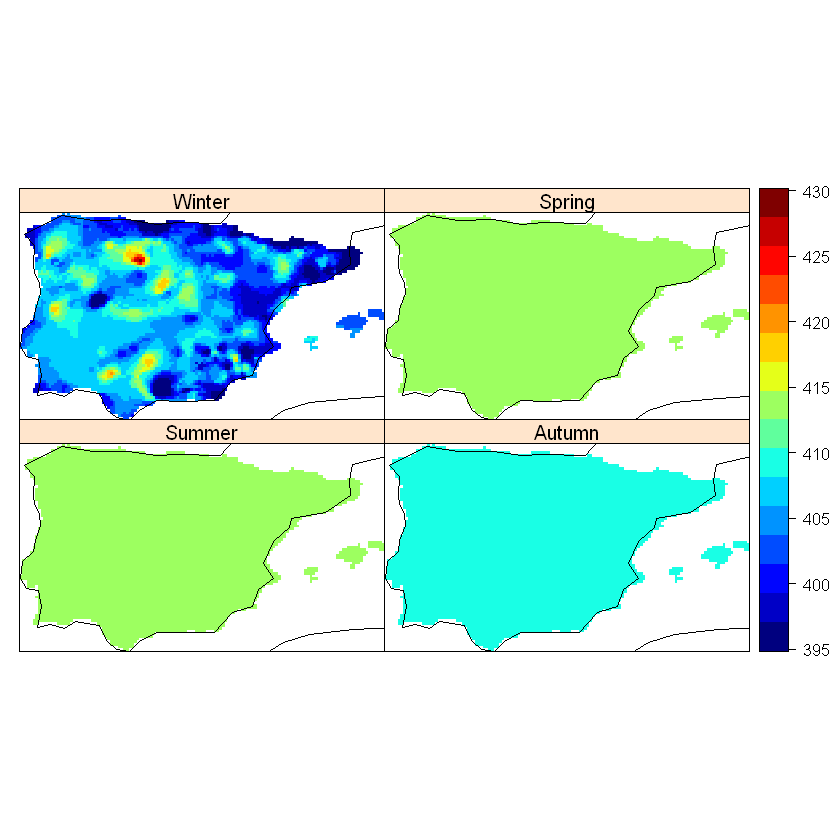

In [23]:
bind3 <- bindGrid(c$Winter, c$Spring, c$Summer, c$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind3, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

CON CAPA TIERRA (1972-2015 Winter / 1971-2015 Rest)

In [24]:
d <- bindGridEstaciones_tierra(sum_tmax_bin_SY_2)

[2024-03-12 13:30:53] - Computing climatology...
[2024-03-12 13:30:53] - Done.
[2024-03-12 13:30:54] - Computing climatology...
[2024-03-12 13:30:54] - Done.
[2024-03-12 13:30:54] - Computing climatology...
[2024-03-12 13:30:54] - Done.
[2024-03-12 13:30:54] - Computing climatology...
[2024-03-12 13:30:54] - Done.


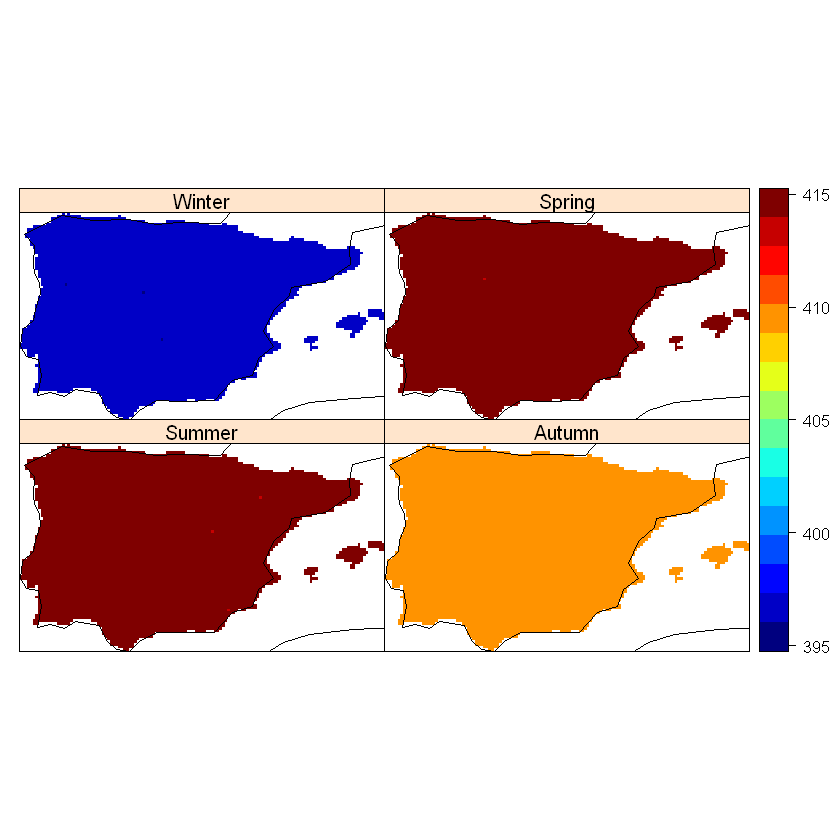

In [25]:
bind4 <- bindGrid(d$Winter, d$Spring, d$Summer, d$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind4, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

In [27]:
saveRDS(tmax_bin_SY, "tmax_season_year_binary.rds",compress = "xz")

In [28]:
saveRDS(tmax_bin_SY_2, "tmax_season_year_binary_2.rds",compress = "xz")